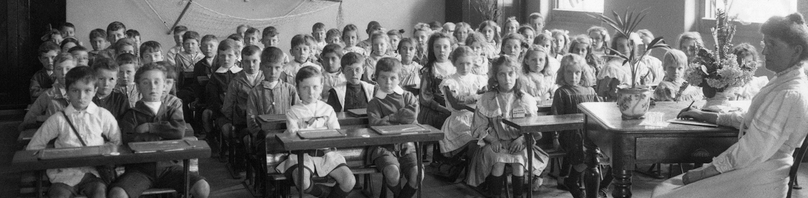
# Riiid!: An EDA of the train.csv file, and then a feature importance via the Random Forest
We shall undertake a very quick data exploration of the `train.csv` file in the [Riiid! Answer Correctness Prediction competition](https://www.kaggle.com/c/riiid-test-answer-prediction). We shall then calculate the importance of the features using the random forest classifier.

### Background reading
Before starting any project, background reading is essential. One should take a look at the paper ["EdNet: A Large-Scale Hierarchical Dataset in Education"](https://arxiv.org/pdf/1912.03072.pdf) as well as the excellent kaggle post by [charliec](https://www.kaggle.com/crained) titled ["Papers on Knowledge Tracing and Education"](https://www.kaggle.com/c/riiid-test-answer-prediction/discussion/188911).
## Contents
* [The train.csv file](#train_file)
* [What data types do we have?](#data_types)
* [pandas describe](#pandas_describe)
* [Unique values: How many unique values are there in the 100K rows?](#unique)
* [Null values: How many null values are there in the 100K rows?](#null)
* [Pivot tables of the categorical fearures](#pivot)
* [Visualisations](#Visualisation)
* [Histograms of the continuous features](#histograms)
* [Create a Pearson correlation matrix](#pearson)
* [Let's see how good the students are...](#how_good)
* [Very quick Permutation Importance with our old friend the Random Forest](#PermutationImportance)
* [Useful links](#useful_links)

In [ ]:
!pip install dabl
import dabl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
colorMap = sns.light_palette("blue", as_cmap=True)

# The train.csv file is big: How to read it in<a class="anchor" id="train_file"></a>
The `train.csv` is large: 5.45G (in fact so large it will not fit in the kaggle notebook memory). Let us see just how many rows it has:

In [ ]:
!wc -l ../input/riiid-test-answer-prediction/train.csv

Indeed we can see that it has 101,230,333 rows.

There are suggestions regarding how to load all of `train.csv` into a kaggle notebook in a [post by ryati](https://www.kaggle.com/c/riiid-test-answer-prediction/discussion/189499) in which they propose trying:
* [Feather binary file format for storing data frames](https://github.com/wesm/feather)
* [Apache Parquet storage format](https://parquet.apache.org/)

Other ideas to look at are
* [Dask](https://docs.dask.org/en/latest/): see the [notebook by  Rajnish Chauhan](https://www.kaggle.com/rajnishe/riiid-read-full-file-dask-api)
* [Datatable](https://datatable.readthedocs.io/en/latest/): see the [notebook by Vopani](https://www.kaggle.com/rohanrao/riiid-with-blazing-fast-rid) with the `.jay` binary format
* [cuDF - GPU DataFrames](https://github.com/rapidsai/cudf) by RAPIDS: see the [notebook by ONODERA](https://www.kaggle.com/onodera/riiid-read-csv-in-cudf)

Vopani has also written an excellent [tutorial on reading large datasets](https://www.kaggle.com/rohanrao/tutorial-on-reading-large-datasets).

It has been [suggested by tkm2261](https://www.kaggle.com/c/riiid-test-answer-prediction/discussion/190270) that [BigQuery](https://cloud.google.com/bigquery) could come in useful in this competition, and it has been confirmed by the kaggle staff that the use of BigQuery is within the competition rules.


That said, for this little notebook we shall just read in the first 100K rows (which is less than 0.1% of the data) using vanilla pandas:

In [ ]:
import pandas as pd
train_data = pd.read_csv('../input/riiid-test-answer-prediction/train.csv', nrows=100000)

# What data types do we have?<a class="anchor" id="data_types"></a>

In [ ]:
dabl.detect_types(train_data)

From this we can see that there are four **continuous** features:
<font color=purple>
* Time features:
 * `timestamp` which is the time between this user interaction and the first event from that user
 * `prior_question_elapsed_time` is the average time a user took to solve each question in the previous bundle. [I.e. if three questions are in a bundle, they share the same `prior_question_elapsed_time` and the value is the total time the user took to solve all three questions, divided by three.](https://www.kaggle.com/c/riiid-test-answer-prediction/discussion/189768)
* Identification features:
 * `content_id` ID code for the user interaction 
 * `task_container_id` ID code for the batch of questions or lectures
<br></font>

Note that `task_container_id` does not increase monotonically for each student, as was mentioned by [Gunes Evitan](https://www.kaggle.com/c/riiid-test-answer-prediction/discussion/189351) and [Zhao Chow](https://www.kaggle.com/c/riiid-test-answer-prediction/discussion/189465), but rather it seems to reflect the order in which the student starts the tasks.

There is one **low cardinality integer** feature, namely
<font color=darkgreen>
* `user_id` which is the ID code for the user.<br>
<br></font>

There are three **categorical** features:<br>
<font color=darkred>
Our target feature:
* `answered_correctly` if the user responded correctly, `0` or `1`, and `-1` for no answer (i.e. watching lectures)
    
and
* `user_answer` the user's answer to the question: `0`, `1`, `2` or `3`, and `-1` for no answer (i.e. watching lectures)
* `content_type_id` which is either:
 * `0` if the event was a question being posed to the user, 
 * `1` if the event was the user watching a lecture
<br></font>

There is one **Boolean** feature, namely:
<font color=darkyellow>
* `prior_question_had_explanation` (`True`/`False`) which is whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between.
<br></font>



## pandas describe<a class="anchor" id="pandas_describe"></a>

Some simple escriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding `NaN` values.

In [ ]:
train_data.describe().style.background_gradient(cmap=colorMap)

## Unique values: How many unique values are there in the 100K rows?<a class="anchor" id="unique"></a>

In [ ]:
for col in train_data:
    print(col,len(train_data[col].unique()))

## Null values: How many null values are there in the 100K rows?<a class="anchor" id="null"></a>

In [ ]:
train_data.isnull().sum()

We can see that there are null values in the columns `prior_question_elapsed_time` and `prior_question_had_explanation` that will need cleaning up.
## Pivot tables of the categorical fearures `user_answer`, `answered_correctly` and the Boolean `prior_question_had_explanation`<a class="anchor" id="pivot"></a>

* `user_answer` "is the user's answer to the question, if any. Read -1 as null, for lectures."

In [ ]:
pd.set_option('display.max_columns', None)
pivot_table = pd.pivot_table(train_data, index=['user_answer']).style.background_gradient(cmap=colorMap)
pivot_table

We can see that other than the `-1` row where thare was a lecture and no question was asked, the variables seem to be pretty much the same for each of the user answers. That said, if you did not know the answer to a particular question then choose `2` as it, albeit slimly, is the most frequent correct answer ;-)

* `answered_correctly` is if the user responded correctly, which is either `0` or `1`, and is `-1` for no answer (i.e. watching lectures)

In [ ]:
pivot_table = pd.pivot_table(train_data, index=['answered_correctly']).style.background_gradient(cmap=colorMap)
pivot_table

the biggest difference between those who answered correctly and those who did not seems to show in `task_container_id` which is the Id code for the batch of questions or lectures.

* `prior_question_had_explanation` which is whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between

In [ ]:
pivot_table = pd.pivot_table(train_data, index=['prior_question_had_explanation']).style.background_gradient(cmap=colorMap)
pivot_table

# Visualisations<a class="anchor" id="Visualisation"></a>

In [ ]:
dabl.plot(train_data, target_col="answered_correctly")

There seems to be a large class imbalance (maybe the [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) package will come in useful?). The very small blue `-1` class corresponds to lectures, where no questions were asked, and can probabbly be excluded.

## Histograms of the continuous features `prior_question_elapsed_time`, `task_container_id` and `content_id`:<a class="anchor" id="histograms"></a>

`prior_question_elapsed_time` is the average time a user took to solve each question in the previous bundle. I.e. if three questions are in a bundle, they share the same `prior_question_elapsed_time` and the value is the total time the user took to solve all three questions, divided by three.

In [ ]:
plt.figure(figsize = (15,6))
# set 300 bins, one bin for each of the 300 time values
ax = sns.distplot(train_data['prior_question_elapsed_time'], kde=False, bins=300)
ax.set_xlim(0,75000)
ax.set_xlabel("Histogram of 'prior_question_elapsed_time'",fontsize=18)
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.show();

In [ ]:
print("The mean prior_question_elapsed_time is: %.1f" % train_data['prior_question_elapsed_time'].mean())
print("The modal value is                     :",train_data['prior_question_elapsed_time'].mode().squeeze())

We can see a distribution of times. (Note: It has not been explicitly stated what the units of time are, [but it has been suggested that it is milliseconds](https://www.kaggle.com/c/riiid-test-answer-prediction/discussion/189763)). 

Let us calculate the [skew](https://en.wikipedia.org/wiki/Skewness) and [kurtosis](https://en.wikipedia.org/wiki/Kurtosis):

In [ ]:
print("Skew of prior_question_elapsed_time is:      %.2f" %train_data['prior_question_elapsed_time'].skew() )
print("Kurtosis of prior_question_elapsed_time is: %.2f" %train_data['prior_question_elapsed_time'].kurtosis() )

Let us take a look at `task_container_id` and `content_id`:

In [ ]:
plt.figure(figsize = (15,6))
ax = sns.distplot(train_data['task_container_id'], kde=False, bins=563)
ax.set_xlim(0,1000)
ax.set_xlabel("Histogram of 'task_container_id'",fontsize=18)
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.show();

In [ ]:
plt.figure(figsize = (15,6))
ax = sns.distplot(train_data['content_id'], kde=False, bins=341) # why 341? Because it is a factor of 32736 ;-)
ax.set_xlim(0,14000)
ax.set_xlabel("Histogram of 'content_id'",fontsize=18)
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.show();

## Create a Pearson correlation matrix<a class="anchor" id="pearson"></a>

In [ ]:
train_data.corr().style.background_gradient(cmap='Oranges')

I do not see any informative or useful correlations. There is a correlation between `task_container_id` (the Id code for the batch of questions or lectures) and `timestamp` which is the the time between this user interaction and the first event from that user. There is also a correlation between `content_type_id` (0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture) and `content_id` the ID code for the user interaction, but I am not sure this is useable.

# Let's see how good the students are...<a class="anchor" id="how_good"></a>
We shall do this by grouping each student (by their `user_id`) and calculating the ratio of correct to incorrect answers. We have `lectures`, which correspond to `-1`, `0` for presumably `incorrect` answers, and `1`for a `correct` answer. So first we shall remove the lectures from the data, then group each `user_id`, then finally calculate the mean of their scores (`answered_correctly`):

In [ ]:
how_good = train_data[train_data['answered_correctly'] != -1].groupby('user_id').mean()

In [ ]:
plt.figure(figsize = (15,6))
ax = sns.distplot(how_good['answered_correctly'], color='darkcyan',bins=50)
ax.set_xlabel("Plot of the ratio of correct to incorrect answers by user",fontsize=18)
ax.set_xlim(0,1)
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.show();

In [ ]:
print("The best score is: %.1f" % (how_good['answered_correctly'].max()*100), "%")
print("The mean score is:  %.1f" % (how_good['answered_correctly'].mean()*100), "%")

#### Notes: 
* Be careful how one uses the `answered_correctly` data as it is a potential source of leakage; see the discussion ["Beware of target leakage"](https://www.kaggle.com/c/riiid-test-answer-prediction/discussion/189437) by [Max Halford](https://www.kaggle.com/maxhalford) for more details. 
* It has been found that some questions are repeated, and when this happens that students are more likely to answer correctly (!). See this excellent notebook ["Statistical Analysis on Repeated questions"](https://www.kaggle.com/aravindpadman/riiid-statistical-analysis-on-repeated-questions) by [Aravind Padmasanan](https://www.kaggle.com/aravindpadman).
* Somewhat unsurprisingly, students who listened to the lectures before answering the questions have a higher rate of `answered_correctly`, as was shown in the notebook ["Utilize Lecture In Your Model & Before Answering"](https://www.kaggle.com/jsylas/utilize-lecture-in-your-model-before-answering) by [Sylas](https://www.kaggle.com/jsylas).

In [ ]:
fig_1 = px.scatter(how_good, x=how_good['prior_question_elapsed_time'], y=how_good['answered_correctly'], 
                   trendline="ols", marginal_y="violin", marginal_x="box",
                   title=("Scatter plot of results with respect to the prior question elapsed time"))
fig_1.show()

There seems to be almost no correlation between the users score and how long it took the user to answer their previous question bundle.

# Very quick Permutation Importance with our old friend the Random Forest<a class="anchor" id="PermutationImportance"></a>
We shall now perform a simple [permutation importance](https://www.kaggle.com/dansbecker/permutation-importance) calculation, a basic way of seeing which features *may* be important. For a list of ideas regarding feature engineering and the Riiid dataset see the discussion ["Any feature engineering ideas?"](https://www.kaggle.com/c/riiid-test-answer-prediction/discussion/192137) by [Pavel Prokhorov](https://www.kaggle.com/pavelvpster).

In [ ]:
X_train       = train_data.drop("answered_correctly",axis=1)
X_train       = X_train.fillna(X_train.mean())
y_train       = train_data["answered_correctly"]

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(max_features='auto', 
                                    min_samples_leaf=10)
classifier.fit(X_train, y_train)

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
perm_import = PermutationImportance(classifier, random_state=1).fit(X_train, y_train)
# visualize the results
eli5.show_weights(perm_import, top=None, feature_names = X_train.columns.tolist())

We can see that `task_container_id` was deemed to be the "most" important. And the least important is `content_type_id`, as was indicated at the start when `dabl.detect_types` went as fas as to call it useless...

Note: 

> Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model. (Source: [scikit-learn permutation importance](https://scikit-learn.org/stable/modules/permutation_importance.html)).

Another option for performing feature importance is by using the more sophisticated [Boruta-SHAP package](https://www.kaggle.com/carlmcbrideellis/feature-selection-using-the-borutashap-package). However, be advised that it does take quite a while to execute.

# Useful links<a class="anchor" id="useful_links"></a>

* [EdNet](https://github.com/riiid/ednet) on GitHub
* [Chol *et al.* "EdNet: A Large-Scale Hierarchical Dataset in Education", arXiv:1912.03072
](https://arxiv.org/pdf/1912.03072.pdf) (pdf)
* ["Papers on Knowledge Tracing and Education"](https://www.kaggle.com/c/riiid-test-answer-prediction/discussion/188911) an excellent kaggle post by [charliec](https://www.kaggle.com/crained) with links to many interesting papers.
 
# Thanks for Riiiding this simple EDA!
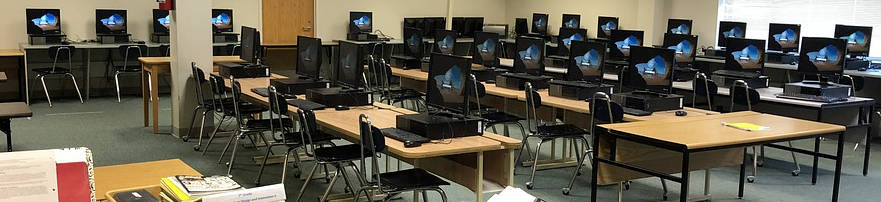